# Cummulative Traffic Exposure


In [1]:
# Import libraries

# System

import os

# Analysis

import numpy as np # Numerical Analysis
import pandas as pd # Data Mgmt
import geopandas as gpd # Spatial Data Mgmt
# from scipy import interpolate as interp # # different interpolators <- Not going this route
import rasterio # Rasters

from scipy.ndimage import convolve # <- this is cool
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve.html

# Visualization

import matplotlib.pyplot as plt # Basic Plotting
plt.style.use('ggplot') # 
import seaborn as sns # Statistical Plotting
import contextily # Base Map Visualization

In [2]:
# Definitions

def Save_array_to_geotiff_template(array, template_path, save_path):
    '''Saves a numpy array into a geotiff with the same CRS as the template.
    '''            

    # Get metadata from template
    rst = rasterio.open(template_path) # Open template
    meta = rst.meta.copy() # Copy template metadata
    # meta.update(compress='lzw') # Good for integers/categorical rasters
    rst.close()

    with rasterio.open(save_path, 'w+', **meta) as out: # Burn features into raster
        out.write_band(1, array)

In [3]:
# Load Data

# Load raster template

raster_path = os.path.join(os.getcwd(), '..', 'template.npy')

raster = np.load(raster_path)

# Minneapolis Boundary

mpls_path = os.path.join(os.getcwd(), '..', '..', '1_Data_IO', 'Data', 'mpls_boundary.geojson')
mpls = gpd.read_file(mpls_path)

# rasterized aadt

aadt_path = os.path.join(os.getcwd(), '..', 'Rasterized_Sources', 'rasterized_aadt.tif')

aadt_rast = rasterio.open(aadt_path) # Open

aadt_band = aadt_rast.read(1)

aadt_rast.close()

In [4]:
# Get some sort of focal statistic? 
# We want cummulative impact which is additive (not just an average value)
# So.. Sort of like a focal_sum but with decay
# Could interpolate and then do a focal sum?

# Wondering about Convolution?
# https://en.wikipedia.org/wiki/Kernel_(image_processing)#Convolution

# Performing an interpolation with a gaussian kernel function

# Define weights kernel

def gkern(l=5, sig=1.):
    """\
    Creates gaussian kernel with side length `l` and a sigma of `sig`
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel #/ np.sum(kernel) <- this is for standardizing.. like a focal sum



kernel = gkern(200, 10) # Gaussian kernel with 10 km diameter and sigma of 10

interp_aadt = convolve(aadt_band, kernel)

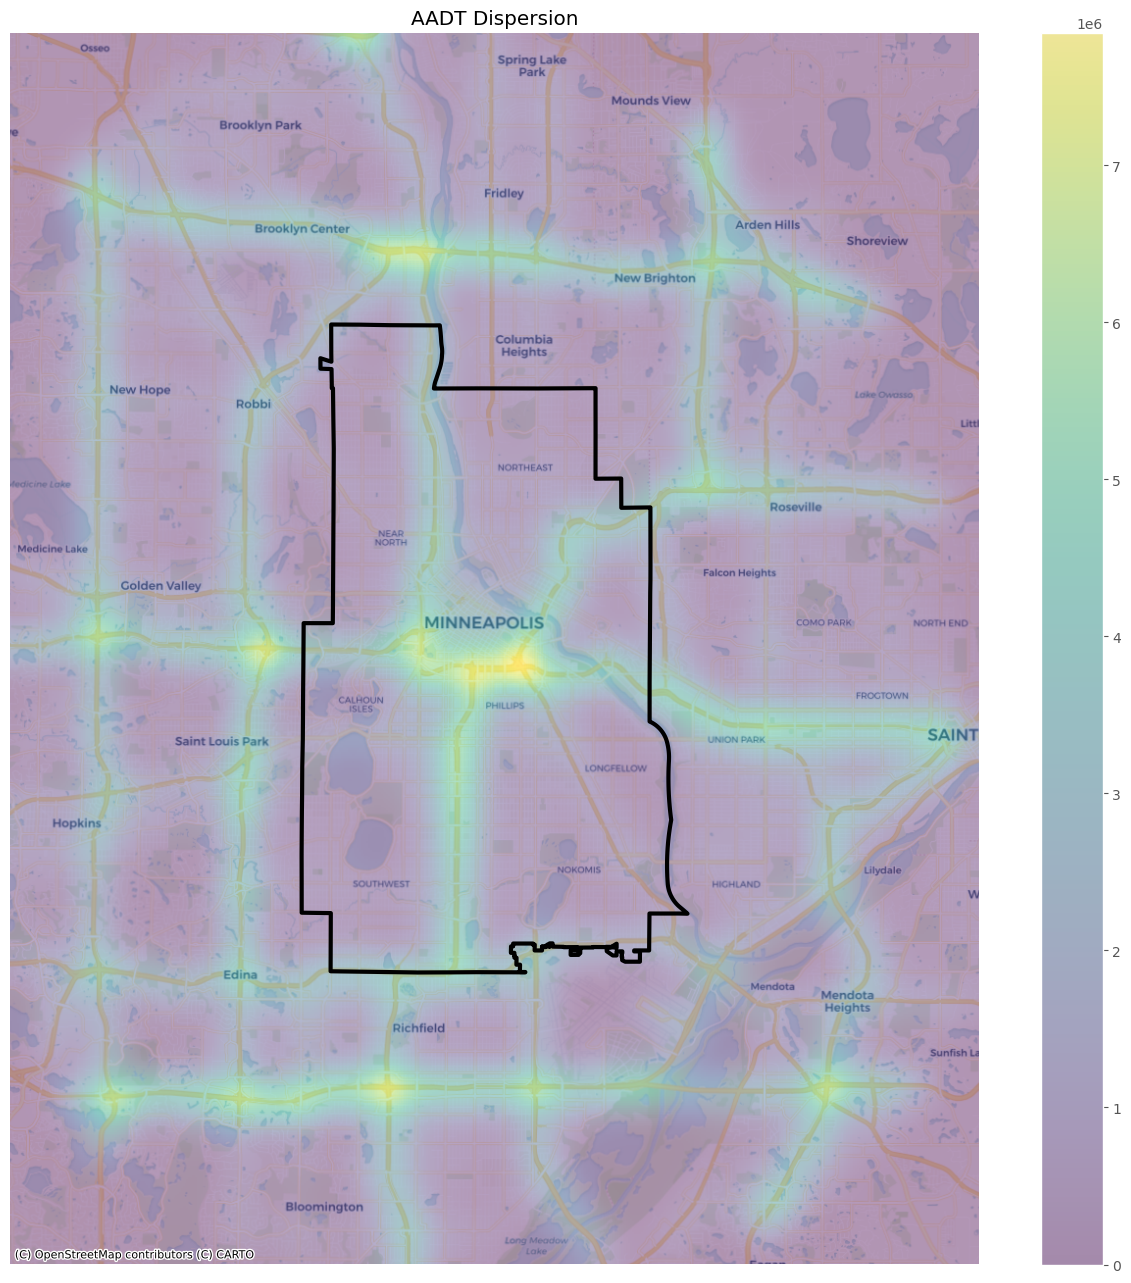

'Rasterized AADT with focal sum of current volume using a non-standardized\ngaussian kernel\n'

In [6]:
# PLOT!

f, ax = plt.subplots(1, figsize=(16,16)) # Initialize frame


art = ax.pcolormesh(raster[0], raster[1], interp_aadt.T, shading='auto', cmap = 'viridis', alpha = 0.4) # Plot interpolation

f.colorbar(art, ax = ax) # Add colorbar
title = 'AADT Dispersion'
ax.set_title(title) # Add title
ax.set_axis_off()

mpls.plot(ax = ax,
         edgecolor='black', facecolor='none',
         linewidth=3,
         zorder = 2,
         legend = True)

# Add basemap

contextily.add_basemap(ax = ax, 
                       crs = 'EPSG:26915', 
                       source=contextily.providers.CartoDB.Voyager
                      ) 
plt.savefig('aadt_dispersed', dpi = 230)
plt.show()

'''Rasterized AADT with focal sum of current volume using a non-standardized
gaussian kernel\n'''

In [6]:
aadt_band.max()

203000.0

In [7]:
interp_aadt.max()

7845466.835695432

In [8]:
# Looks cool! Notice that this really compounds along the roadways... 
# But I think it's better than interpolating from the centroids of the segments!

## Explore Raster Statistics

<AxesSubplot: ylabel='Count'>

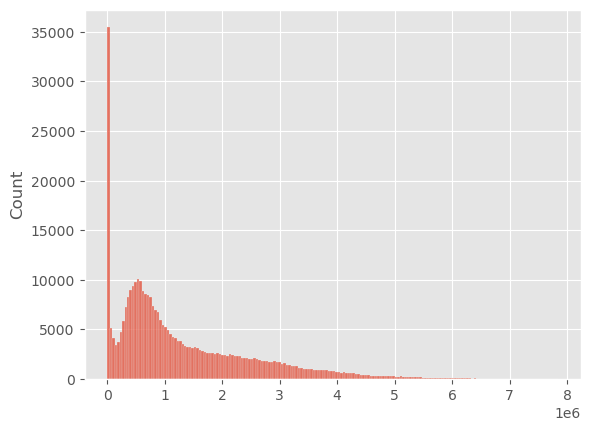

In [9]:
expose_sum = interp_aadt.sum()
expose_mean = interp_aadt.mean()
expose_median = np.median(interp_aadt)

values = interp_aadt.flatten()


sns.histplot(values)

<AxesSubplot: ylabel='Count'>

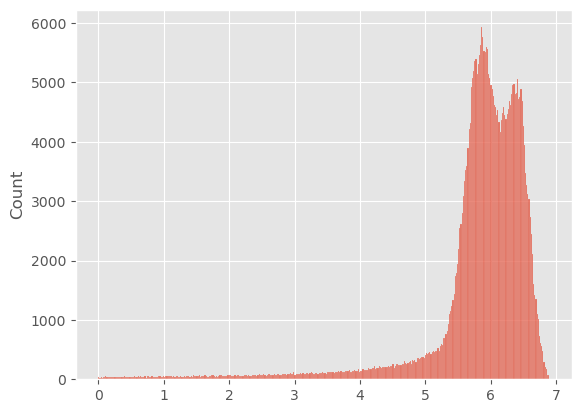

In [10]:
# Heavy tail, remove values less than 1 and try logarithm?

big_values = values[values>1]

big_values_log = np.log10(big_values)

sns.histplot(big_values_log)

In [11]:
# Multimodal... Curious

## Standardize

In [12]:
# We're not log transforming

# std_rast = interp_aadt.copy()

# small_indices = interp_aadt<1
# big_indices = interp_aadt>1
# big_indices_sum = interp_aadt[big_indices].sum()

# std_rast[small_indices] = 0
# std_rast[big_indices] = np.log10(std_rast[big_indices])

# std_rast[big_indices] = std_rast[big_indices]/std_rast[big_indices].max()

In [13]:
# Just normalizing!!

    
std_rast = interp_aadt.copy()

std_rast = std_rast/std_rast.max()


<AxesSubplot: ylabel='Count'>

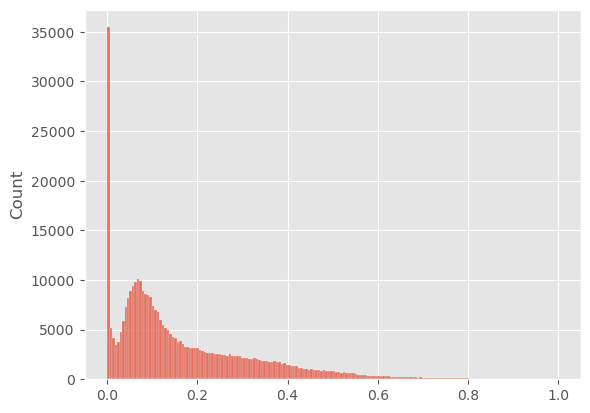

In [14]:
sns.histplot(std_rast.flatten())

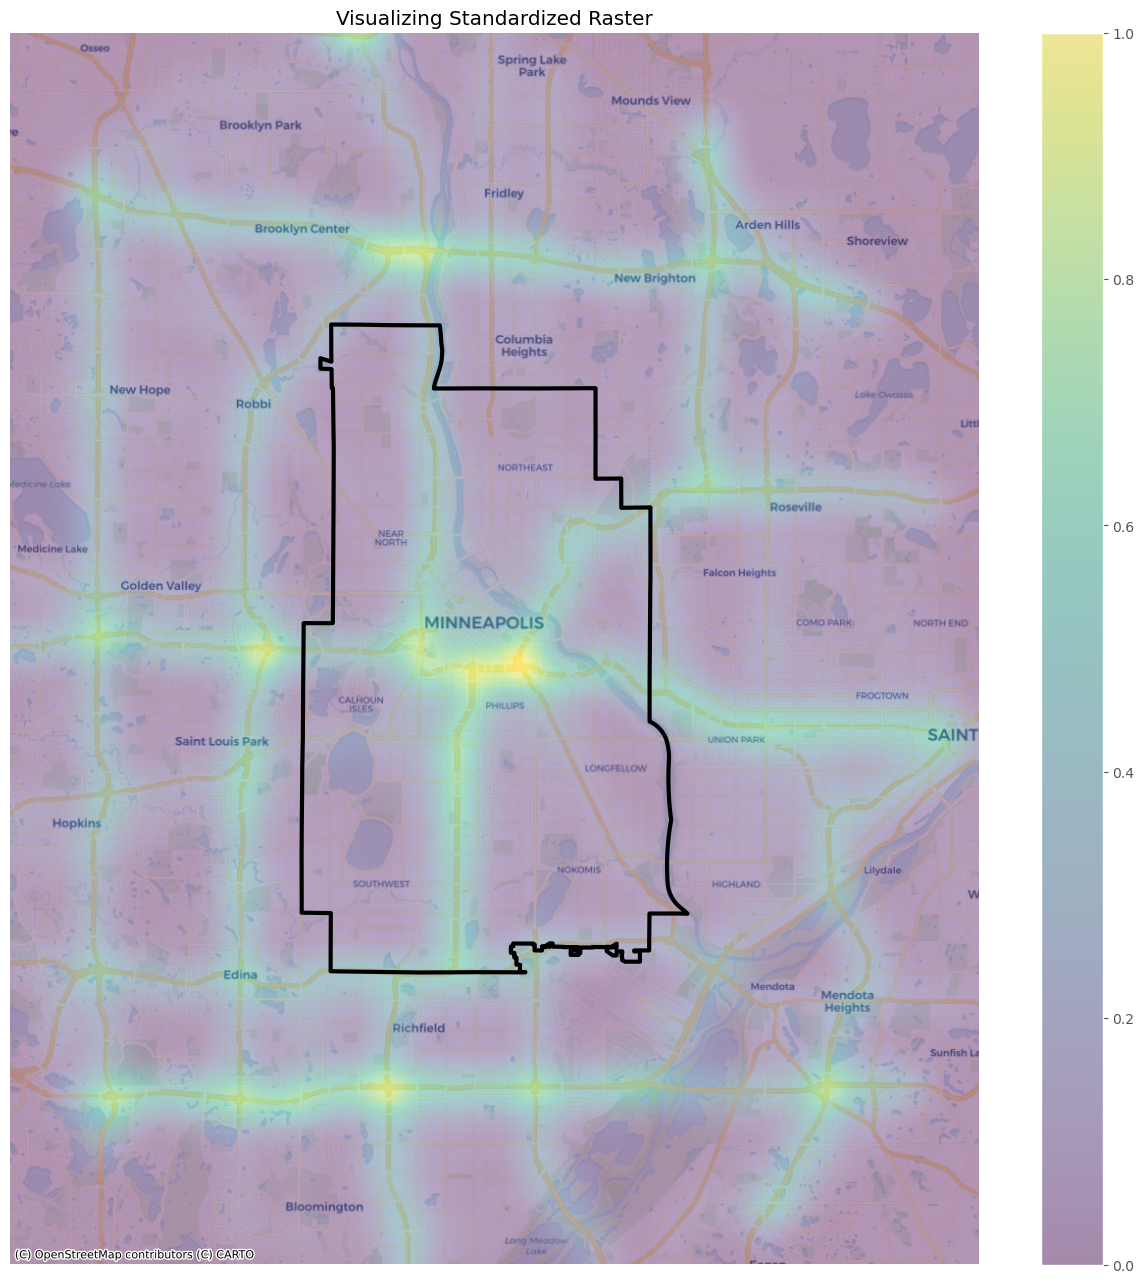

In [15]:
# PLOT!

f, ax = plt.subplots(1, figsize=(16,16)) # Initialize frame


art = ax.pcolormesh(raster[0], raster[1], std_rast.T, shading='auto', cmap = 'viridis', alpha = 0.4) # Plot interpolation

f.colorbar(art, ax = ax) # Add colorbar
title = '''Visualizing Standardized Raster'''
ax.set_title(title) # Add title
ax.set_axis_off()

mpls.plot(ax = ax,
         edgecolor='black', facecolor='none',
         linewidth=3,
         zorder = 2,
         legend = True)

# Add basemap

contextily.add_basemap(ax = ax, 
                       crs = 'EPSG:26915', 
                       source=contextily.providers.CartoDB.Voyager
                      ) 

plt.show()

In [16]:
# Save

Save_array_to_geotiff_template(std_rast, '../template.tif', '../Modeled_Exposure/AADT_exposure.tif')
             

## Interpolate!?

### Get Coordinates of Segment Centroids

In [17]:
# Get Coordinates

x = aadt_select.geometry.centroid.x
y = aadt_select.geometry.centroid.y

coords = np.array(list(zip(x,y)))

NameError: name 'aadt_select' is not defined

In [16]:
## First attempt

interpolator = interp.RBFInterpolator(y = coords,
                                      d = aadt_select['CURRENT_VO'].values,
                                      smoothing = 0.1,
                                      kernel = 'linear',
                                      epsilon = .04) # These worked okay?

Z = interpolator(raster.reshape(2, -1).T).reshape(raster[0].shape)

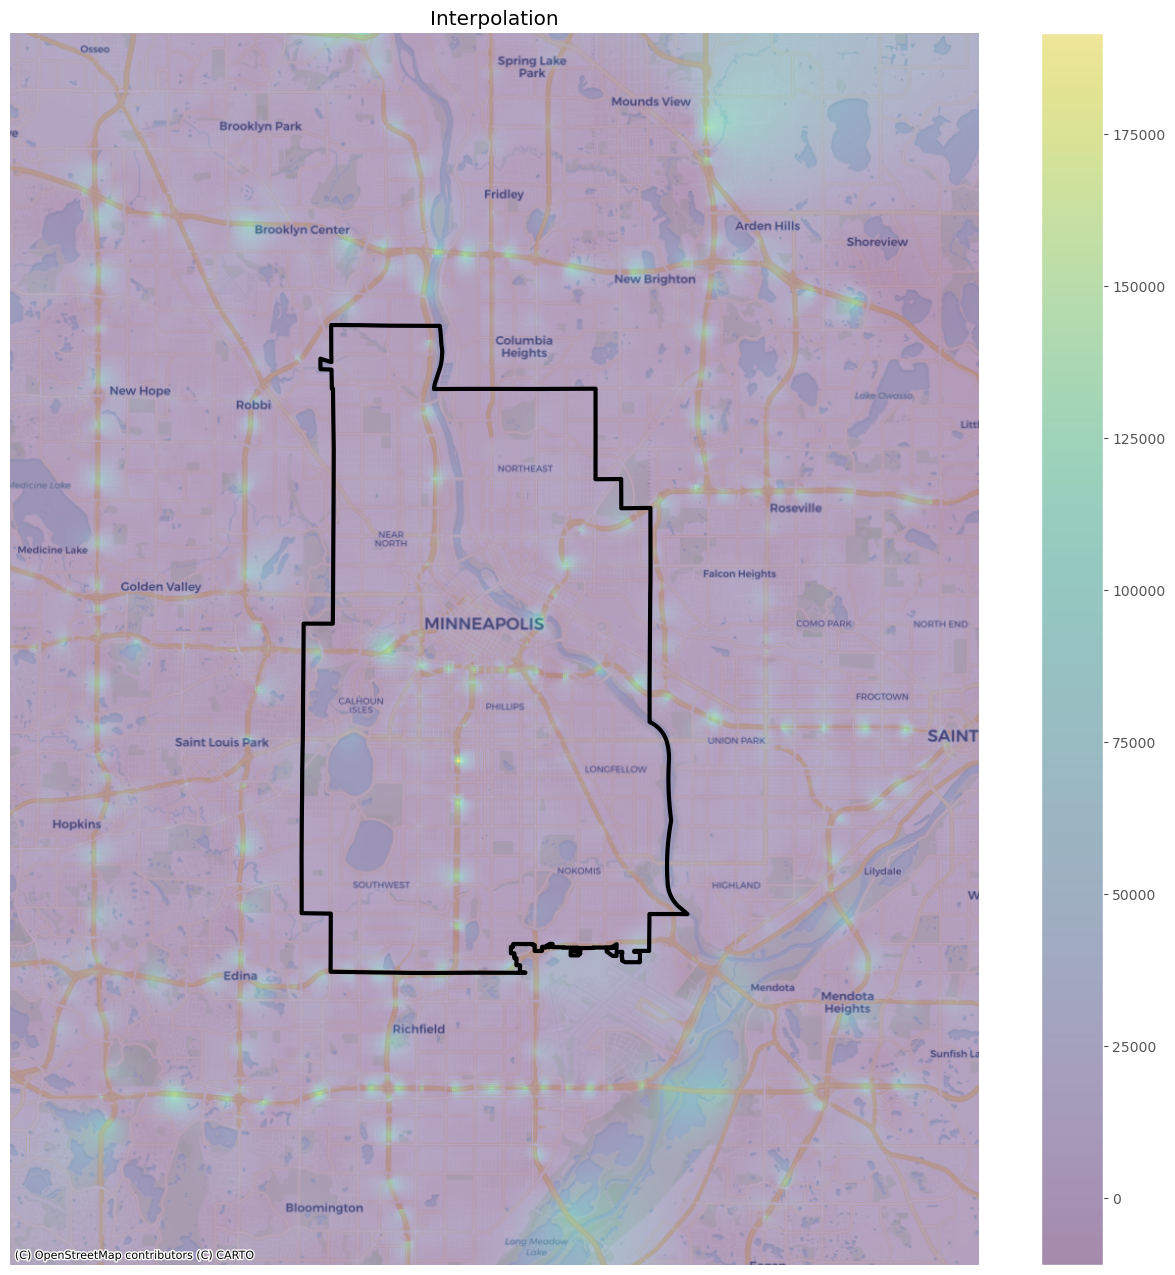



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




In [17]:
# PLOT!

f, ax = plt.subplots(1, figsize=(16,16)) # Initialize frame


art = ax.pcolormesh(raster[0], raster[1], Z, shading='auto', cmap = 'viridis', alpha = 0.4) # Plot interpolation

f.colorbar(art, ax = ax) # Add colorbar
title = 'Interpolation'
ax.set_title(title) # Add title
ax.set_axis_off()

mpls.plot(ax = ax,
         edgecolor='black', facecolor='none',
         linewidth=3,
         zorder = 2,
         legend = True)

# Add basemap

contextily.add_basemap(ax = ax, 
                       crs = 'EPSG:26915', 
                       source=contextily.providers.CartoDB.Voyager
                      ) 

plt.show()
print('\n\n ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n\n')

In [ ]:
# That ain't right